<a href="https://colab.research.google.com/github/PMatthaei/pymarl-results/blob/master/visualize_pymarl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Visualization of PyMARL experiments

This notebook visualizes results of experiments conducted on PyMARL.

Main repository: https://github.com/oxwhirl/pymarl

Fork: https://github.com/PMatthaei/pymarl

Results repository: https://github.com/PMatthaei/pymarl-results


In [1]:
!git clone https://github.com/PMatthaei/pymarl-results.git

Cloning into 'pymarl-results'...
remote: Enumerating objects: 735, done.
remote: Counting objects: 100% (735/735), done.
remote: Compressing objects: 100% (622/622), done.
remote: Total 735 (delta 199), reused 556 (delta 89), pack-reused 0
Receiving objects: 100% (735/735), 35.13 MiB | 30.59 MiB/s, done.
Resolving deltas: 100% (199/199), done.


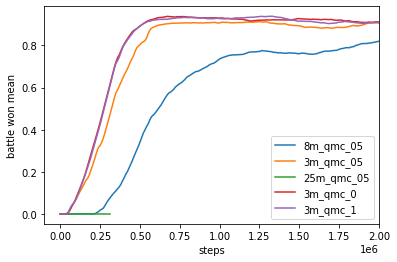

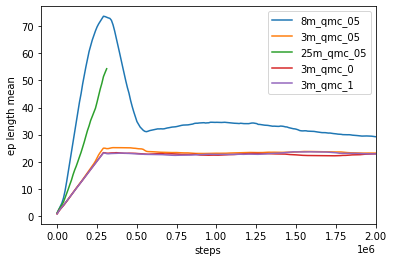

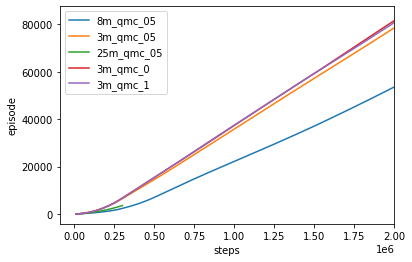

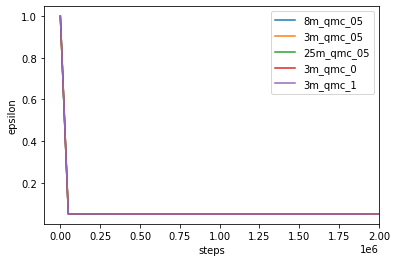

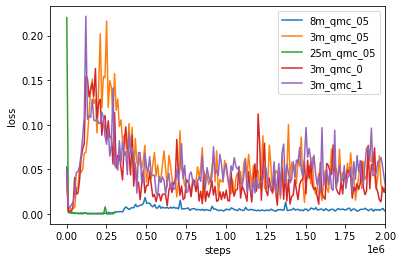

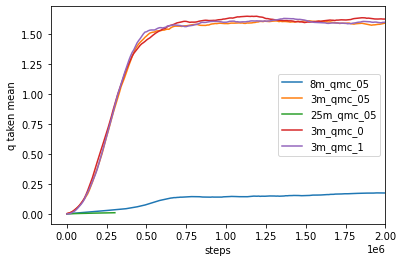

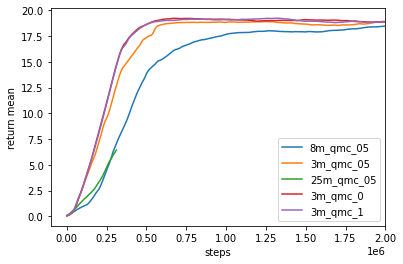

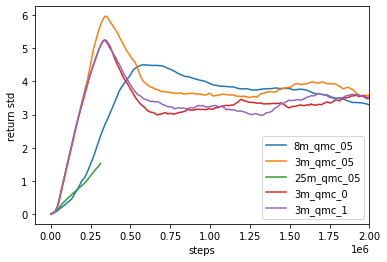

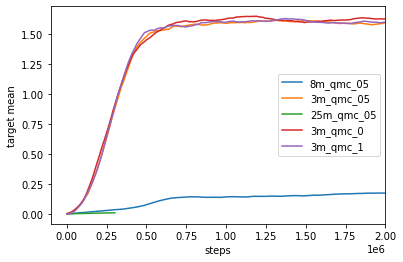

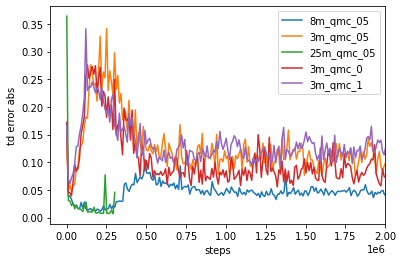

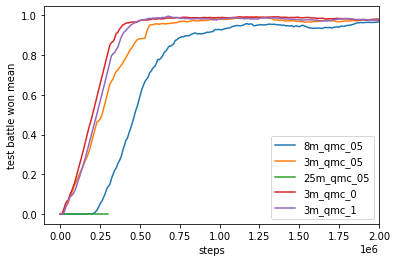

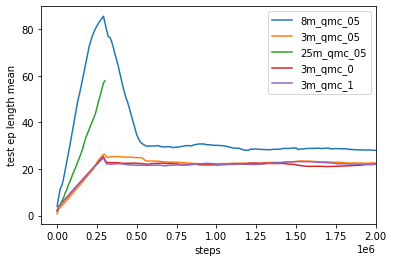

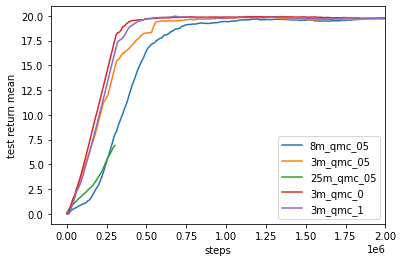

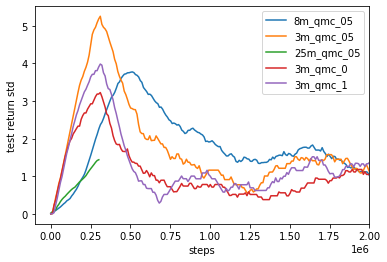

In [7]:
#@title Choose your experiments { run: "auto" }

#@markdown Choose algorithms
qmix = False #@param {type:"boolean"}
qmc = True #@param {type:"boolean"}
vdn = False #@param {type:"boolean"}
vdnc = False #@param {type:"boolean"}
iql = False #@param {type:"boolean"}
coma = False #@param {type:"boolean"}
qtran = False #@param {type:"boolean"}

#@markdown Choose environments
three_marines = False #@param {type:"boolean"}
eight_marines = False #@param {type:"boolean"}
twentyfive_marines = False #@param {type:"boolean"}
three_stalkers_five_zealots = False #@param {type:"boolean"}

# Fetch form data
envs = []
if three_marines: envs.append('3m')
if eight_marines: envs.append('8m')
if twentyfive_marines: envs.append('25m')
if three_stalkers_five_zealots: envs.append('3s5z')

algos = []
if qmix: algos.append('qmix')
if qmc: algos.append('qmc')
if vdn: algos.append('vdn')
if vdnc: algos.append('vdc')
if iql: algos.append('iql')
if coma: algos.append('coma')
if qtran: algos.append('qtran')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import re

from scipy.signal import lfilter
from pathlib import Path

plot_data = {}
metrics = []

def extract_plot_data():
  # Fetch all paths to info.json of every commited experiment
  for path in Path('/content/pymarl-results').rglob('*info*.json'):
    # Extract label from path
    label = extract_label(path, algos+envs)

    # If the path corresponds to a env or an algo we want to plot 
    if is_algo(path, algos) and is_env(path, envs):
      # Read json
      with open(path) as json_file:
          data = json.load(json_file)
          for metric in data:
            # Transposed corresponds to xs values. We identify metrics by ys
            if '_T' not in metric:
              # If we have not already seen this metric in a json -> add to plots
              if metric not in metrics:
                metrics.append(metric)

              # Get data for this metric and the current experiment
              transposed_identifier = metric+'_T'
              xs = data[transposed_identifier]
              ys = data[metric]

              # Save the experiment data in the plot dict and provide label
              if metric in plot_data:
                plot_data[metric].append((xs, ys, label))
              else:
                plot_data[metric] = []
                plot_data[metric].append((xs, ys, label))
                
# Smoothing parameters
n = 30  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
not_smooth = ['epsilon', 'td_error_abs', 'loss']
def plot():
  for metric in metrics:
    # Exclude for now since weird jsons are returned
    if metric == 'grad_norm':
      continue

    for i, data in enumerate(plot_data[metric]):
      # If plot data is hidden in a dict property 'value' -> unpack
      ys = list(map(lambda x: x['value'] if isinstance(x,dict) else x, data[1]))
      xs = data[0]
      if metric in not_smooth:
        # Dont smooth all metrics included
        plt.plot(xs, ys, label=data[2])
      else:
        # Smooth via direct II transposed structure
        plt.plot(xs, lfilter(b,a,ys), label=data[2])

      plt.xlabel('steps')
      plt.xlim(right=2000000) # Experiments end at 2 million steps
      metric_label = metric.replace('_', ' ')
      plt.ylabel(metric_label)

    plt.legend(loc='best')
    plt.savefig(metric+'.png')
    plt.show()

def is_env(path, envs):
  if len(envs) == 0:
    return True
  # Test for all paths if they correspond to a selected environment
  return any(env in str(path) for env in envs)

def is_algo(path, algos):
  if len(algos) == 0:
    return True
  # Test for all paths if they correspond to a selected algorithm
  return any(algo in str(path) for algo in algos)

def extract_label(path, search):
  # Match folder name which will serve as label
  return re.search(".*(results/)(.*)(/source).*",str(path))[2]

# main 
extract_plot_data()
plot()